# Exercise 8: BLOBs and SIFT features
Solutions for the week 8 exercises. We follow the terminology from the lecture notes on scale-space and local features.

## BLOB detector
The Difference-of-Gaussians (DoG) operator approximates the scale-normalized Laplacian-of-Gaussian and highlights blob-like structures.

### Exercise 8.1
Construct a scale space pyramid without downsampling. Each level is obtained by smoothing the input image with increasingly wider Gaussian kernels.

In [1]:

import numpy as np
import cv2
from skimage import data
import matplotlib.pyplot as plt

def scaleSpaced(im, sigma, n):
    """Return list of n Gaussian smoothed images.
    sigma_i = sigma * 2**i
    """
    im_scales = []
    for i in range(n):
        s = sigma * (2**i)
        blur = cv2.GaussianBlur(im, ksize=(0,0), sigmaX=s, sigmaY=s)
        im_scales.append(blur)
    return im_scales


### Exercise 8.2
Compute the DoG volume by subtracting adjacent levels of the scale space.

In [2]:

def differenceOfGaussians(im, sigma, n):
    scales = scaleSpaced(im, sigma, n)
    DoG = []
    for i in range(n-1):
        DoG.append(scales[i+1] - scales[i])
    return DoG


### Exercise 8.3
Detect blob responses using non-maximum suppression in the 3-D DoG volume. Only local extrema with magnitude above a threshold are kept.

In [3]:

def detectBlobs(im, sigma, n, tau):
    DoG = differenceOfGaussians(im, sigma, n)
    kernel = np.ones((3,3), np.uint8)
    maxDog = [cv2.dilate(np.abs(d), kernel) for d in DoG]
    blobs = []
    for i, d in enumerate(DoG):
        m = (np.abs(d) == maxDog[i]) & (np.abs(d) > tau)
        if i > 0:
            m &= np.abs(d) > maxDog[i-1]
        if i < len(DoG)-1:
            m &= np.abs(d) > maxDog[i+1]
        ys, xs = np.where(m)
        r = np.sqrt(2) * sigma * (2**i)
        for y, x in zip(ys, xs):
            blobs.append((x, y, r))
    return blobs


(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

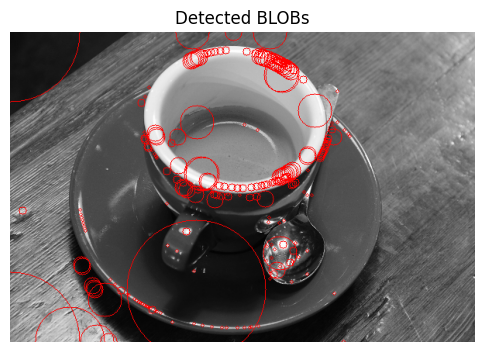

In [4]:

# Demonstration on a flower image (coffee used as placeholder for sunflowers).
im = data.coffee()
im = im.astype(float).mean(2)/255.0
blobs = detectBlobs(im, sigma=2, n=7, tau=0.1)
color = cv2.cvtColor((im*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
for x,y,r in blobs:
    cv2.circle(color, (int(x), int(y)), int(r), (0,0,255), 1)
plt.figure(figsize=(6,6))
plt.imshow(color[...,::-1])
plt.title('Detected BLOBs')
plt.axis('off')


## Using SIFT features
SIFT extracts scale and rotation invariant keypoints with distinctive descriptors.

### Exercise 8.4
Apply a similarity transform consisting of a rotation and uniform scale.

(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

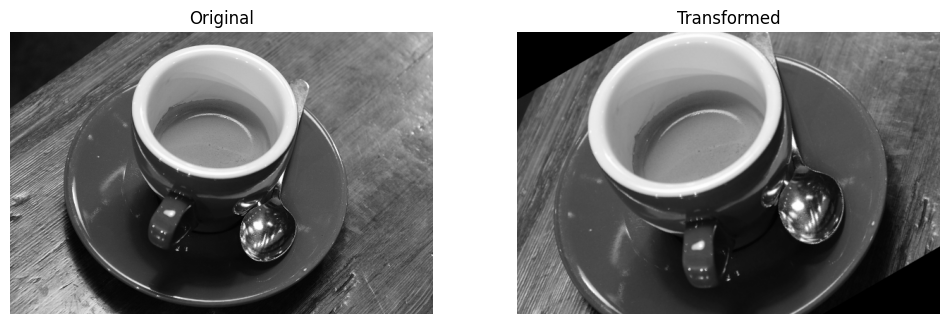

In [5]:

def transformIm(im, theta, s):
    h, w = im.shape[:2]
    M = cv2.getRotationMatrix2D((w/2, h/2), theta, s)
    return cv2.warpAffine(im, M, (w, h))

transformed = transformIm((im*255).astype(np.uint8), 30, 1.2)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow((im*255).astype(np.uint8), cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(transformed, cmap='gray'); plt.title('Transformed'); plt.axis('off')


### Exercise 8.5
Use the SIFT detector and descriptor to find correspondences between the original and transformed images. Filter matches with Lowe's ratio test.

(np.float64(-0.5), np.float64(1199.5), np.float64(399.5), np.float64(-0.5))

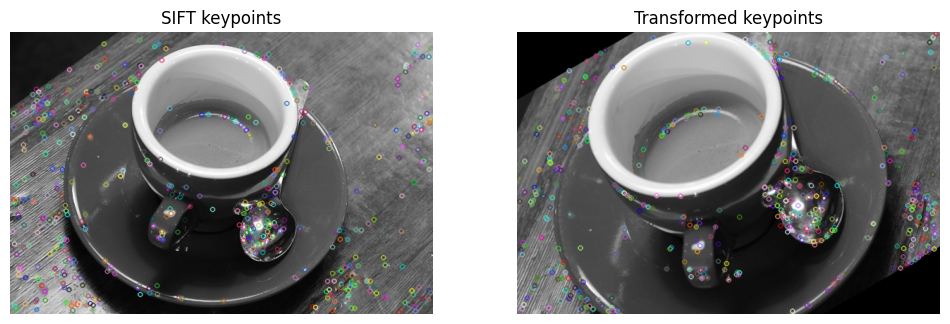

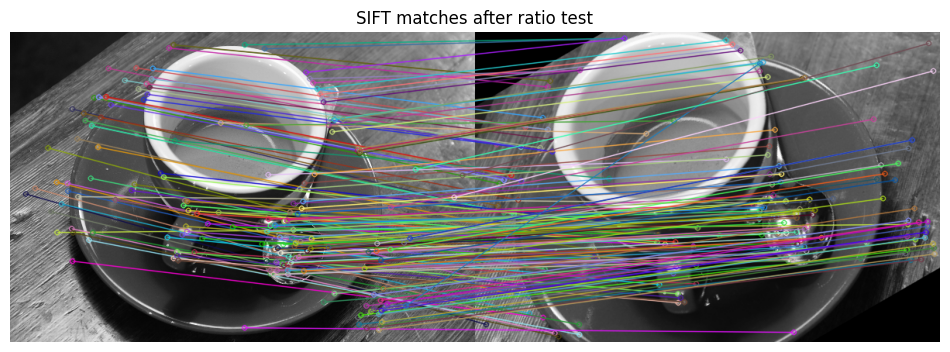

In [6]:

sift = cv2.SIFT_create()
key1, des1 = sift.detectAndCompute((im*255).astype(np.uint8), None)
key2, des2 = sift.detectAndCompute(transformed, None)
img1_kp = cv2.drawKeypoints((im*255).astype(np.uint8), key1, None)
img2_kp = cv2.drawKeypoints(transformed, key2, None)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(img1_kp); plt.title('SIFT keypoints'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img2_kp); plt.title('Transformed keypoints'); plt.axis('off')

BF = cv2.BFMatcher()
matches = BF.knnMatch(des1, des2, k=2)
ratio_matches = [m for m,n in matches if m.distance < 0.75*n.distance]
match_img = cv2.drawMatches((im*255).astype(np.uint8), key1, transformed, key2, ratio_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12,6))
plt.imshow(match_img); plt.title('SIFT matches after ratio test'); plt.axis('off')


### Exercise 8.6
Match SIFT features between two images of the same scene taken from different viewpoints.

(np.float64(-0.5), np.float64(1481.5), np.float64(499.5), np.float64(-0.5))

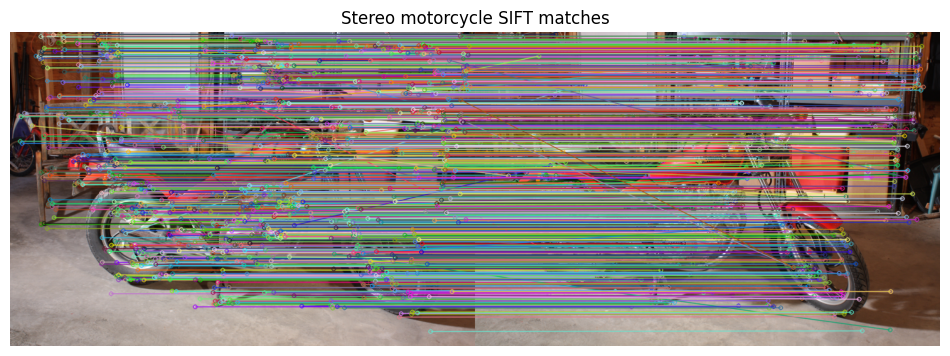

In [7]:

left, right, _ = data.stereo_motorcycle()
left_gray = cv2.cvtColor(left, cv2.COLOR_RGB2GRAY)
right_gray = cv2.cvtColor(right, cv2.COLOR_RGB2GRAY)
kp1, des1 = sift.detectAndCompute(left_gray, None)
kp2, des2 = sift.detectAndCompute(right_gray, None)
match = BF.knnMatch(des1, des2, k=2)
ratio = [m for m,n in match if m.distance < 0.75*n.distance]
img_match = cv2.drawMatches(left, kp1, right, kp2, ratio, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12,6))
plt.imshow(img_match); plt.title('Stereo motorcycle SIFT matches'); plt.axis('off')


### Exercise 8.7 (optional)
The optional R2D2 feature matcher is not demonstrated here.